In [2]:
import torch as t
from torch import nn


<font color=red size=4>这里还有一些问题</font>

In [60]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features):
#         nn.Module.__init__(self)
        super(Linear, self).__init__()
        self.w = nn.Parameter(t.randn(in_features, out_features))
        self.b = nn.Parameter(t.randn(out_features))
# 下买你这样写会报错:
#  The expanded size of the tensor (4) must match the existing size (3) at non-singleton dimension 1
#    def forward(self,x):
#       return x.mm(self.w) + self.b.expand_as(x)
    def forward(self, x):
        x = x.mm(self.w) # x.@(self.w)
        return x + self.b.expand_as(x)
    

In [61]:
layer = Linear(4,3)
input = t.randn(2,4)
output = layer(input) # 与钩子技术有关,之后看一下
output 

tensor([[-0.3912,  2.0798, -2.4181],
        [ 4.0932,  0.6451, -2.2826]])

In [9]:
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Perceptron,self).__init__()
        self.layer1 = Linear(in_features, hidden_features)
        self.layer2 = Linear(hidden_features,out_features)
    def forward(self,x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)
perceptron = Perceptron(3,4,1)
for name,param in perceptron.named_parameters():
    print(name,param.size())
    


layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 1])
layer2.b torch.Size([1])
Object `nn.layer` not found.


<a>

可见，即使是稍复杂的多层感知机，其实现依旧很简单。这里新增两个知识点：

    * 构造函数__init__中，可利用前面自定义的Linear层(module)，作为当前module对象的一个子module，它的可学习参数，也会成为当前module的可学习参数。
    * 在前向传播函数中，我们有意识地将输出变量都命名成x，是为了能让Python回收一些中间层的输出，从而节省内存。但并不是所有都会被回收，有些variable虽然名字被覆盖，但其在反向传播仍需要用到，此时Python的内存回收模块将通过检查引用计数，不会回收这一部分内存。

module中parameter的命名规范：

    * 对于类似self.param_name = nn.Parameter(t.randn(3, 4))，命名为param_name
    * 对于子Module中的parameter，会其名字之前加上当前Module的名字。如对于self.sub_module = SubModel()，SubModel中有个parameter的名字叫做param_name，那么二者拼接而成的parameter name 就是sub_module.param_name。

为方便用户使用，PyTorch实现了神经网络中绝大多数的layer，这些layer都继承于nn.Module，封装了可学习参数parameter，并实现了forward函数，且很多都专门针对GPU运算进行了CuDNN优化，其速度和性能都十分优异。本书不准备对nn.Module中的所有层进行详细介绍，具体内容读者可参照官方文档1或在IPython/Jupyter中使用nn.layer?来查看。阅读文档时应主要关注以下几点：

    * 构造函数的参数，如nn.Linear(in_features, out_features, bias)，需关注这三个参数的作用。
    属性，可学习参数，子module。如nn.Linear中有weight和bias两个可学习参数，不包含子module。
    * 输入输出的形状，如nn.linear的输入形状是(N, input_features)，输出为(N，output_features)，N是batch_size。

<font color=red size=4>这些自定义layer对输入形状都有假设：输入的不是单个数据，而是一个batch。若想输入一个数据，则必须调用unsqueeze(0)函数将数据伪装成batch_size=1的batch</font>
</a>

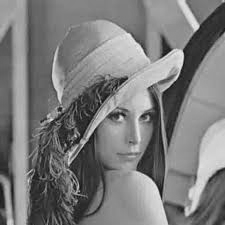

In [18]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()
to_pil = ToPILImage()
lena = Image.open('/home/ai/Pictures/lena.jpg')
lena = lena.convert('L')
lena

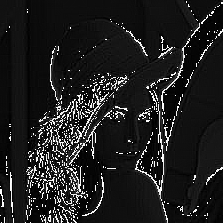

In [41]:
input = to_tensor(lena).unsqueeze(0)
to_pil(input.squeeze(0))
# input.size() = 1,1,225,225
# 锐化卷积核
kernel = t.ones(3,3)/-9
kernel[1][1] = 1
conv = nn.Conv2d(1, 1, (3,3), 1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)

out = conv(input)
# out.size() = 1,1,233,233
to_pil(out.squeeze(0))


池化层可以看作是一种特殊的卷积层，用来下采样。但池化层没有可学习参数，其weight是固定的。

In [34]:
pool = nn.AvgPool2d(2,2)
list(pool.parameters())

[]

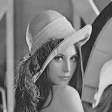

In [47]:
out = pool(input)
to_pil(out.squeeze(0))


In [48]:
input = t.randn(2,3)
linear = nn.Linear(3,4)
h = linear(input)
h

tensor([[-0.1017,  0.2879,  0.6018,  0.7971],
        [-0.5313,  0.8622,  0.9481,  0.2176]])

<a>
* Linear：全连接层。
* BatchNorm：批规范化层，分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用到的InstanceNorm层。
* Dropout：dropout层，用来防止过拟合，同样分为1D、2D和3D。 下面通过例子来说明它们的使用。
</a>

In [62]:
# 输入batch_size=2 ， 维度3
input = t.randn(2,3)
linear = nn.Linear(3,4)
h = linear(input)
h

tensor([[ 0.2222,  0.2986,  0.6062, -0.4640],
        [ 0.8176, -0.6060, -0.0528,  0.2783]])

In [70]:
# 4 channel，初始化标准差为4，均值为0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4) * 4
bn.bias.data = t.zeros(4)

bn_out = bn(h)
# 注意输出的均值和方差
# 方差是标准差的平方，计算无偏方差分母会减1
# 使用unbiased=False 分母不减1
bn_out.mean(0), bn_out.var(0, unbiased=False)

(tensor(1.00000e-07 *
        [ 3.5763,  0.0000,  1.1921,  0.0000]),
 tensor([ 15.9982,  15.9992,  15.9985,  15.9988]))

In [71]:
# 每个元素以0.5的概率舍弃
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o # 有一半左右的数变为0

tensor([[-0.0000,  7.9998,  7.9996, -7.9997],
        [ 7.9995, -0.0000, -7.9996,  0.0000]])

<font color=red size=4>其大多数是可学习参数，一般会随着学习的进行而不断改变。实际使用中除非需要使用特殊的初始化，应尽量不要直接修改这些参数。</font>

In [72]:
relu = nn.ReLU(inplace=True)
input = t.randn(2,3)
print(input)

tensor([[ 1.4657,  0.6670, -0.1958],
        [ 0.9162, -1.4085,  0.9082]])


In [3]:
import torch as t
from torch import nn
relu = nn.ReLU(inplace=True)
input = t.randn(2,3)
print(input)
output = relu(input) # 小于0的都被截断为0
print(output)

tensor([[-2.0708,  0.2298,  1.2668],
        [-0.2610,  0.8063,  0.8718]])
tensor([[ 0.0000,  0.2298,  1.2668],
        [ 0.0000,  0.8063,  0.8718]])


<a>
简化前馈网络（feedforward neural network）的方式：
* Sequential，特殊的module，包含几个子Module，前向传播时会将输入一层接一层的传递下去
* ModuleList，一个特殊的module，可以包含几个子module，可以像用list一样使用它，但不能直接把输入传给ModuleList。

</a>

In [23]:
# Sequential的三种写法
# 这种写法比较好， 既可以通过index访问，可以通过str访问
net1 = nn.Sequential()
net1.add_module('conv', nn.Conv2d(3, 3, 3))
net1.add_module('batchnorm', nn.BatchNorm2d(3))
net1.add_module('activation_layer', nn.ReLU())

In [34]:
net2 = nn.Sequential(
        nn.Conv2d(3, 3, 3),
        nn.BatchNorm2d(3),
        nn.ReLU()
        )

In [30]:
from collections import OrderedDict
net3 = nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(3, 3, 3)),
        ('bn', nn.BatchNorm2d(3)),
        ('relu', nn.ReLU())
        ]))

In [26]:
print('net1:', net1)
print('net2:', net2)
print('net3:', net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)


In [27]:
# 根据名字或许号取出子module
net1[0], net2[0], net3.conv

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)))

In [35]:
from torch.autograd import Variable as V
input = V(t.rand(1, 3, 4, 4))
# 如果把batchnorm 改成2 会报错running_mean should contain 3 elements not 2
output = net1(input)
output = net2(input)
output = net3(input)
output = net3.relu(net1.batchnorm(net1.conv(input)))

In [37]:
modellist = nn.ModuleList([nn.Linear(3,4), nn.ReLU(), nn.Linear(4,2)])
input = V(t.randn(1, 3))
for model in modellist:
    input = model(input)
# 下面会报错,因为modellist没有实现forward方法
# output = modelist(input)


tensor([[-0.3944,  0.3578]])

<a>
损失函数 loss function
</a>

可以看作是特殊的一层，pytorch将其实现为nn.Module的子类

In [40]:
# batch_size=3，计算对应每个类别的分数（只有两个类别）
score = t.randn(3, 2)
# 三个样本分别属于1，0，1类，label必须是LongTensor
label = t.Tensor([1, 0 ,1]).long()

# loss与普通的layer无差异
criterion = nn.CrossEntropyLoss()
loss = criterion(score, label)
loss

tensor(0.7662)

### 优化器

<font color=red size=4>这里很重要</font>
封装在torch.optim,所有的优化方法都是继承基类optim.Optimizer
<a>

    优化方法的基本使用方法
    如何对模型的不同部分设置不同的学习率
    如何调整学习率

</a>

In [42]:
# 首先定义一个LeNet网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
                    nn.Conv2d(3, 6, 5),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2),
                    nn.Conv2d(6, 16, 5),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
                    nn.Linear(16 * 5 * 5, 120),
                    nn.ReLU(),
                    nn.Linear(120, 84),
                    nn.ReLU(),
                    nn.Linear(84, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16* 5 * 5)
        x = self.classifier(x)
        return x

net = Net()

<font color=red size=4>这里为什么要梯度清零</font>

In [45]:
from torch import optim
optimizer = optim.SGD(params=net.parameters(), lr=1)
# 梯度清零， 等价于net.zero_grad()
optimizer.zero_grad() 

input = t.randn(1, 3, 32, 32)
output = net(input)
output.backward(output)

optimizer.step()# 执行优化


In [47]:
# 为不同子网络设置不同的学习率，在finetune中经常用到
# 如果对某个参数不指定学习率，就使用最外层的默认学习率
optimizer = optim.SGD([
                {'params': net.features.parameters()},
                {'params': net.classifier.parameters(), 'lr': 1e-2}
            ], lr=1e-5)

In [48]:
# 只为两个全连接层设置较大的学习率，其余层的学习率较小
special_layers = nn.ModuleList([net.classifier[0], net.classifier[2]])
special_layers_params = list(map(id, special_layers.parameters()))
base_params = filter(lambda p: id(p) not in special_layers_params,
                     net.parameters())

optimizer = t.optim.SGD([
            {'params': base_params},
            {'params': special_layers.parameters(), 'lr': 0.01}
        ], lr=0.001 )


<font color = red>对于如何调整学习率，主要有两种做法。一种是修改optimizer.param_groups中对应的学习率，另一种是更简单也是较为推荐的做法——新建优化器，由于optimizer十分轻量级，构建开销很小，故而可以构建新的optimizer。但是后者对于使用动量的优化器（如Adam），会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况。</font>

In [49]:
# 调整学习率，新建一个optimizer
old_lr = 0.1
optimizer =optim.SGD([
                {'params': net.features.parameters()},
                {'params': net.classifier.parameters(), 'lr': old_lr*0.1}
            ], lr=1e-5)

## nn.functional

用nn.Module实现的layers是一个特殊的类，都是由class layer(nn.Module)定义，会自动提取可学习的参数。而nn.functional中的函数更像是纯函数，由def function(input)定义nn.中nn中的大多数layer，在functional中都有一个与之相对应的函数。


In [70]:

input = t.randn(2, 3)
modle = nn.Linear(3, 4)
output1 = model(input)

output2 = nn.functional.linear(input, model.weight, model.bias)
print(output1 == output2)

tensor([[ 1,  1,  1,  1],
        [ 1,  1,  1,  1]], dtype=torch.uint8)


In [63]:
b = nn.functional.relu(input)
b2 = nn.ReLU()(input)
b == b2

tensor([[ 1,  1,  1],
        [ 1,  1,  1]], dtype=torch.uint8)

<font color=blue>什么时候使用nn.Module,和torch.nn.functional</font>

此时读者可能会问，应该什么时候使用nn.Module，什么时候使用nn.functional呢？答案很简单，如果模型有可学习的参数，最好用nn.Module，否则既可以使用nn.functional也可以使用nn.Module，二者在性能上没有太大差异，具体的使用取决于个人的喜好。如激活函数（ReLU、sigmoid、tanh），池化（MaxPool）等层由于没有可学习参数，则可以使用对应的functional函数代替，而对于卷积、全连接等具有可学习参数的网络建议使用nn.Module。下面举例说明，如何在模型中搭配使用nn.Module和nn.functional。另外虽然dropout操作也没有可学习操作，但建议还是使用nn.Dropout而不是nn.functional.dropout，因为dropout在训练和测试两个阶段的行为有所差别，使用nn.Module对象能够通过model.eval操作加以区分。

<font color=red size=4>这里的pool是什么pool，我官网都查不到</font>

In [67]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.pool(F.relu(self.conv1(x)), 2)
        x = F.pool(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


对于不具备可学习参数的层（激活层、池化层等），将它们用函数代替，这样则可以不用放置在构造函数__init__中。对于有可学习参数的模块，也可以用functional来代替，只不过实现起来较为繁琐，需要手动定义参数parameter，如前面实现自定义的全连接层，就可将weight和bias两个参数单独拿出来，在构造函数中初始化为parameter。

In [68]:
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear, self).__init__()
        self.weight = nn.Parameter(t.randn(3, 4))
        self.bias = nn.Parameter(t.zeros(3))
    def forward(self,input):
        return F.linear(input, self.weight, self.bias)

## 初始化策略
PyTorch中nn.Module的模块参数都采取了较为合理的初始化策略，因此一般不用我们考虑。

当我们在使用Parameter时，自定义初始化则尤为重要，因t.Tensor()返回的是内存中的随机数，很可能会有极大值，这在实际训练网络中会造成溢出或者梯度消失。PyTorch中nn.init模块就是专门为初始化而设计，如果某种初始化策略nn.init不提供，用户也可以自己直接初始化。

In [82]:
# 利用nn.init初始化
from torch.nn import init
linear = nn.Linear(3, 4)

t.manual_seed(1)
print(linear.weight)
# 等价于 linear.weight.data.normal_(0, std)
init.xavier_normal_(linear.weight)


Parameter containing:
tensor([[-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579],
        [ 0.1613,  0.5476,  0.3811],
        [-0.5260, -0.5489, -0.2785]])


Parameter containing:
tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

<font color=red size=4
>这里有问题：weight是nn.Parameter， 是tensor的子类，为什么还要用data</font>

In [89]:
# 直接初始化
import math
t.manual_seed(1)

# xavier初始化的计算公式
std = math.sqrt(2)/math.sqrt(7.)

linear.weight.data.normal_(0,std)

tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

In [91]:
# 对模型的所有参数进行初始化
for name, params in net.named_parameters():
    print(name, params)
    if name.find('linear') != -1:
        # init linear
        params[0] # weight
        params[1] # bias
    elif name.find('conv') != -1:
        pass
    elif name.find('norm') != -1:
        pass
# 'asda'.find('a')
# Out[3]: 
# 0

# 即返回第一个find参数在原str中的位置索引。

features.0.weight Parameter containing:
tensor([[[[-0.0399,  0.0281, -0.0992, -0.0981, -0.0228],
          [ 0.0458,  0.0274,  0.0291, -0.0374, -0.0003],
          [ 0.0847, -0.0981,  0.0361,  0.0547, -0.0990],
          [-0.0900,  0.1128, -0.0398,  0.0380,  0.0645],
          [-0.0560,  0.0408,  0.0437,  0.0437,  0.0540]],

         [[-0.0686, -0.1009,  0.0621,  0.0740,  0.0082],
          [-0.0227,  0.0834, -0.0014, -0.1008, -0.0904],
          [ 0.0271,  0.0548,  0.0031,  0.0090,  0.0650],
          [-0.0506,  0.0337, -0.0153, -0.0605, -0.0983],
          [-0.0473,  0.0174, -0.0787, -0.0487, -0.0991]],

         [[ 0.0792,  0.0257, -0.0137,  0.1099,  0.0169],
          [-0.0822, -0.0525,  0.0622, -0.0808, -0.0515],
          [-0.0436,  0.0555,  0.0341,  0.0193,  0.0810],
          [-0.0389, -0.0772,  0.0153,  0.0117,  0.0520],
          [-0.0886, -0.0511, -0.0197,  0.0424,  0.0484]]],


        [[[ 0.0546, -0.0072,  0.0958, -0.0591, -0.0306],
          [-0.1025,  0.0087,  0.0189, -0

## nn.Module的深入分析

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.param1 =nn.Parameter(t.rand(3, 3))
        self.submodel1 = nn.Linear(3, 4)
    def forward(self, input):
        x = self.param1.mm(input)
        x = self.submodel1(x)
        return x
net = Net()
net

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

In [6]:
net._modules


OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [7]:
net._parameters

OrderedDict([('param1', Parameter containing:
              tensor([[ 0.4955,  0.8847,  0.5418],
                      [ 0.2525,  0.5242,  0.8458],
                      [ 0.2466,  0.4285,  0.0889]]))])

In [8]:
net.param1 # 等价于net._parameters['param1']

Parameter containing:
tensor([[ 0.4955,  0.8847,  0.5418],
        [ 0.2525,  0.5242,  0.8458],
        [ 0.2466,  0.4285,  0.0889]])

In [9]:
for name, param in net.named_parameters():
    print(name, param.size())

param1 torch.Size([3, 3])
submodel1.weight torch.Size([4, 3])
submodel1.bias torch.Size([4])


In [10]:
bn = nn.BatchNorm1d(2)
input = t.rand(3, 2, requires_grad=True)
output= bn(input)
bn._buffers

OrderedDict([('running_mean', tensor(1.00000e-02 *
                     [ 6.6399,  4.6857])),
             ('running_var', tensor([ 0.9016,  0.9144]))])

<a>
* nn.Module.children 可以查看直接子module
* nn.Module.module 可以查看所有的所有的子module（包括当前module）
    
    与之相对应的还有函数named_childen和named_modules，其能够在返回module列表的同时返回它们的名字。
</a>

In [20]:
input = t.arange(1, 13).view(3, 4)
model = nn.Dropout()
# 在训练阶段，会有一半左右的数被随机置为0
model(input)

tensor([[  2.,   4.,   6.,   0.],
        [  0.,  12.,  14.,   0.],
        [  0.,   0.,  22.,  24.]])

In [21]:
model.training = False
# 在测试阶段，dropout什么都不做
model(input)

tensor([[  1.,   2.,   3.,   4.],
        [  5.,   6.,   7.,   8.],
        [  9.,  10.,  11.,  12.]])

<a>
<font color=red>batchnorm、dropout、instancenorm等在训练和测试阶段行为差距巨大的层，如果在测试时不将其training值设为True，则可能会有很大影响</font>这在实际使用中要千万注意。虽然可通过直接设置training属性，来将子module设为train和eval模式，但这种方式较为繁琐，因如果一个模型具有多个dropout层，就需要为每个dropout层指定training属性。
    
    更为推荐的做法是:
* model.train(): 它会将当前module及其子module中的所有training属性都设为True
* 对应的model.eval()函数会把training属性都设为False。

</a>

In [27]:
print(net.training, net.submodel1.training)
net.train()
net.training, net.submodel1.training

True True


(True, True)

In [28]:
list(net.named_modules())

[('', Net(
    (submodel1): Linear(in_features=3, out_features=4, bias=True)
  )), ('submodel1', Linear(in_features=3, out_features=4, bias=True))]

钩子技术，先不学，点击这里查看https://github.com/chenyuntc/pytorch-book/blob/master/chapter4-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%B7%A5%E5%85%B7%E7%AE%B1nn/chapter4.ipynb

## 保存模型与GPU运行


In [29]:
# 保存模型
t.save(net.state_dict(), 'net.pth')

# 加载已保存的模型
net2 = Net()
net2.load_state_dict(t.load('net.pth'))



将Module放在GPU上运行也十分简单，只需两步：
* model = model.cuda()：将模型的所有参数转存到GPU
* input.cuda()：将输入数据也放置到GPU上

至于如何在多个GPU上并行计算，PyTorch也提供了两个函数，可实现简单高效的并行GPU计算

* nn.parallel.data_parallel(module, inputs, device_ids=None, output_device=None, dim=0, module_kwargs=None)
* class torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)

可见二者的参数十分相似，通过device_ids参数可以指定在哪些GPU上进行优化，output_device指定输出到哪个GPU上。唯一的不同就在于前者直接利用多GPU并行计算得出结果，而后者则返回一个新的module，能够自动在多GPU上进行并行加速。

method 1:
new_net = nn.DataParallel(net, device_ids=[0, 1])
output = new_net(input)

method 2:
output = nn.parallel.data_parallel(new_net, input, device_ids=[0, 1])

DataParallel并行的方式，是将输入一个batch的数据均分成多份，分别送到对应的GPU进行计算，各个GPU得到的梯度累加。与Module相关的所有数据也都会以浅复制的方式复制多份，<font color=red>在此需要注意，在module中属性应该是只读的。</font>


## nn.module和nn.autograd.Function对比：
* autograd.Function利用了Tensor对autograd技术的扩展，为autograd实现了新的运算op，不仅要实现前向传播还要手动实现反向传播
* nn.Module利用了autograd技术，对nn的功能进行扩展，实现了深度学习中更多的层。只需实现前向传播功能，autograd即会自动实现反向传播
* nn.functional是一些autograd操作的集合，是经过封装的函数

如果某一个操作，在autograd中尚未支持，那么只能实现Function接口对应的前向传播和反向传播。如果某些时候利用autograd接口比较复杂，则可以利用Function将多个操作聚合，实现优化，正如第三章所实现的Sigmoid一样，比直接利用autograd低级别的操作要快。而如果只是想在深度学习中增加某一层，使用nn.Module进行封装则更为简单高效。

In [2]:
from torch import nn
import torch as t
import torch.nn.functional as F

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1, shotcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, 3, stride, 1, bias=False),
                nn.BatchNorm2d(outchannel),
                nn.ReLU(inplace=True),
                nn.Conv2d(outchannel, outchannel, 3, 1, 1, bias=False),
                nn.BatchNorm2d(outchannel)
                )
        self.right = shortcut
    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        
        
        
        